In [3]:
import os

import numpy as np
import scipy
from IPython.display import Image

from keras.preprocessing.image import load_img, img_to_array, save_img
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.utils import plot_model
import keras.backend as K

Using TensorFlow backend.


In [ ]:
# layer_contributions = {
#     'mixed2': 0.2,
#     'mixed3': 3.,
#     'mixed4': 2.,
#     'mixed5': 1.5,
#     }
layer_contributions = {
    'conv2d_52': 25.,
    }

In [ ]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    return img

In [ ]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    x = np.copy(x)
    x = x.reshape((x.shape[1], x.shape[2], 3))    
    x /=2
    x += 0.5
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x 

In [ ]:
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

In [9]:
model = InceptionV3(weights='imagenet', include_top=False)
layer_dict = {layer.name : layer for layer in model.layers}

In [10]:
loss = K.variable(0.)
for layer_name, coeff in layer_contributions.items():
    output = layer_dict[layer_name].output
    scale = K.cast(K.prod(K.shape(output)), 'float32')
    loss += coeff * K.sum(K.square(output[:, 2:-2, 2:-2, :])) / scale


In [ ]:
dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

fetch_loss_grads = K.function([dream], [loss, grads])

def eval_loss_grads(x):
    loss_value, grad_values = fetch_loss_grads([x])
    return loss_value, grad_values

def gradient_ascent(img, iterations, lr, max_loss=None):
    for i in range(iterations):
        loss_value , grad_values = eval_loss_grads(img)
        print(f'iter {i}, loss_value {loss_value}')
        if max_loss is not None and loss_value > max_loss:
            break
        img += lr * grad_values
    return img

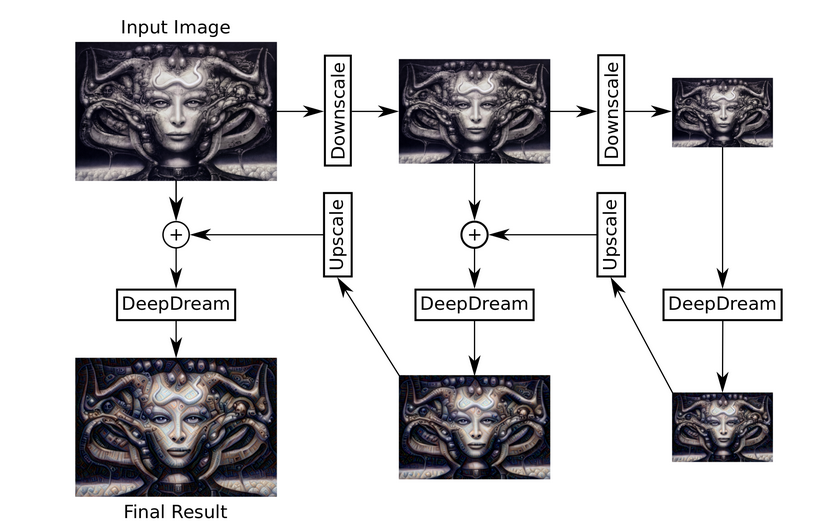

In [12]:
Image('scaling_process.png')

In [13]:
"""Process:
- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.
To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.
"""

'Process:\n- Load the original image.\n- Define a number of processing scales (i.e. image shapes),\n    from smallest to largest.\n- Resize the original image to the smallest scale.\n- For every scale, starting with the smallest (i.e. current one):\n    - Run gradient ascent\n    - Upscale image to the next scale\n    - Reinject the detail that was lost at upscaling time\n- Stop when we are back to the original size.\nTo obtain the detail lost during upscaling, we simply\ntake the original image, shrink it down, upscale it,\nand compare the result to the (resized) original image.\n'

In [ ]:
# Playing with these hyperparameters will also allow you to achieve new effects
lr = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
# max_loss = 10.
max_loss = 100.
image_path = 'sky.jpg'
result_path = 'sky_dream.jpg'

In [15]:
img = preprocess_image(image_path)
original_shape = img.shape[1:-1]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale**i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes.reverse()
original_img = np.copy(img)
shrunk_original_img = resize_img(original_img, successive_shapes[0])
print(shrunk_original_img.shape, original_img.shape)

(1, 366, 653, 3) (1, 718, 1280, 3)


In [16]:
for shape in successive_shapes:
    print(f'processing shape {shape}')
    img = resize_img(img, shape)
    img = gradient_ascent(img, iterations, lr, max_loss)

    downscale_original_image = resize_img(original_img, shape)
    upscale_shrunk_original_image = resize_img(shrunk_original_img, shape)
    lost_details = downscale_original_image - upscale_shrunk_original_image
    img += lost_details

    shrunk_original_img = resize_img(original_img, shape)
save_img(result_path, deprocess_image(img))

processing shape (366, 653)
iter 0, loss_value 4.447455406188965
iter 1, loss_value 6.882779598236084
iter 2, loss_value 9.762666702270508
iter 3, loss_value 12.436530113220215
iter 4, loss_value 15.468106269836426
iter 5, loss_value 19.023662567138672
iter 6, loss_value 22.46673011779785
iter 7, loss_value 25.165185928344727
iter 8, loss_value 28.255294799804688
iter 9, loss_value 31.487403869628906
iter 10, loss_value 34.66889572143555
iter 11, loss_value 38.478736877441406
iter 12, loss_value 42.27123260498047
iter 13, loss_value 44.944026947021484
iter 14, loss_value 48.86606216430664
iter 15, loss_value 50.97712326049805
iter 16, loss_value 55.04623031616211
iter 17, loss_value 56.81414031982422
iter 18, loss_value 60.56361389160156
iter 19, loss_value 63.7132568359375
processing shape (512, 914)
iter 0, loss_value 11.044402122497559
iter 1, loss_value 20.541419982910156
iter 2, loss_value 25.2351016998291
iter 3, loss_value 30.169513702392578
iter 4, loss_value 34.645484924316406

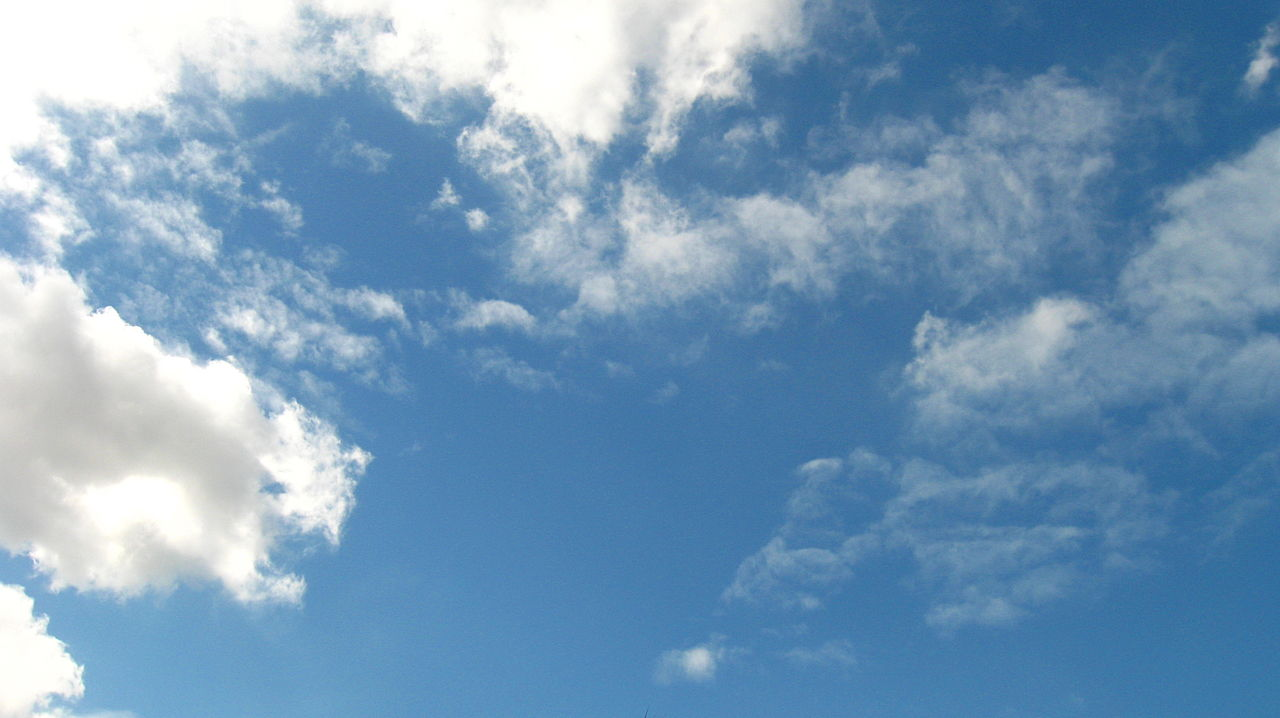

In [17]:
Image(image_path)

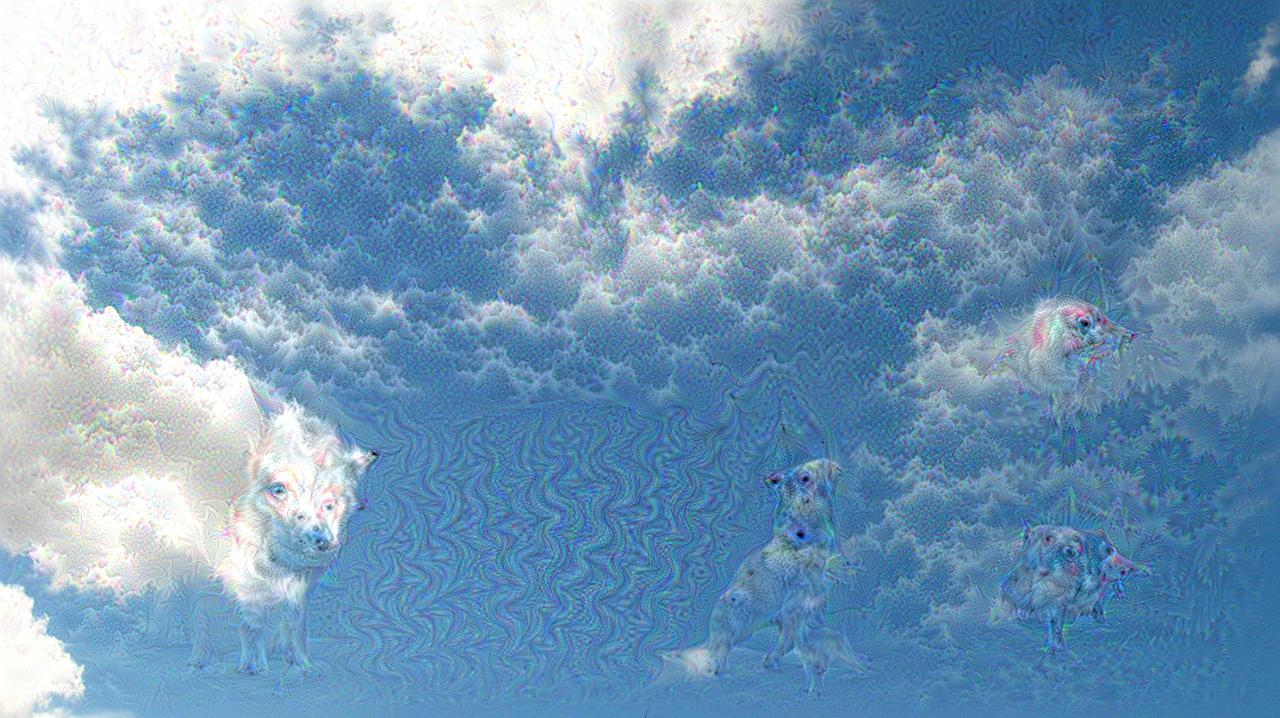

In [18]:
Image(result_path)